In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
# from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys

## functions

In [2]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [3]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

## load data

In [29]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

In [30]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

In [32]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data_train = data_train.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=nmf_data, how="left", on="SK_ID_CURR")

In [33]:
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")

In [34]:
features = list(data_train.columns)
features.remove("SK_ID_CURR")
print(len(features))

1422


In [35]:
len(set(features))

1422

## train & validate

### param0

In [36]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.76623731737172618

0.76450360090667746

### param1

In [10]:
xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.02,
     "max_depth": 8,
     "min_child_weight": 40,
     "gamma": 0,
     "subsample": 0.8715623,
     "colsample_bytree": 0.632,
     "alpha": 0.041545473,
     "lambda": 0.0735294,
     "nrounds": 250
}

# xgb_clf = XgbWrapper(params=xgb_params)
# # xgb_clf.train(X_num_train, y_train)
# # pred_val = xgb_clf.predict(X_num_val)
# roc_auc_score(y_val, pred_val)

0.76213752306289995

## feature selection

In [37]:
import null_importance as ni
from imp import reload
reload(ni)

<module 'null_importance' from 'D:\\git\\kaggle-Home-Credit-Default-Risk\\null_importance.py'>

In [41]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

In [42]:
X_num_train_fillna.shape, X_num_train.shape

((25803, 3422), (25803, 1422))

In [23]:
y_train.shape

(25803,)

In [24]:
len(features)

1422

In [43]:
X_num_train_fillna = X_num_train.copy()
X_num_train_fillna[np.isnan(X_num_train_fillna)] = -1
actual_imp = ni.nrun_randomforest_importance(X_num_train_fillna, y_train, features, n_run=5)

In [54]:
null_imp = ni.nrun_randomforest_importance(X_num_train_fillna, y_train, features, n_run=5, shuffle=True)

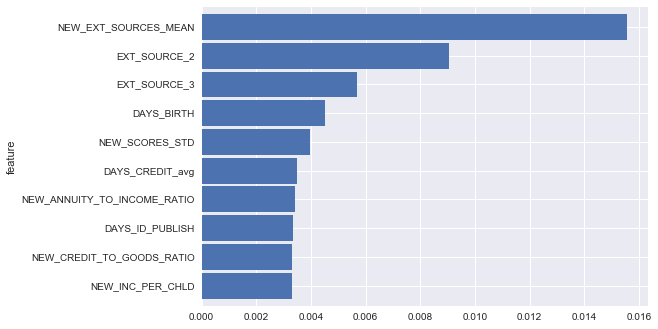

In [57]:
actual_imp.groupby("feature").importance.mean().sort_values().tail(10).plot(kind="barh", width=.9)
plt.show()

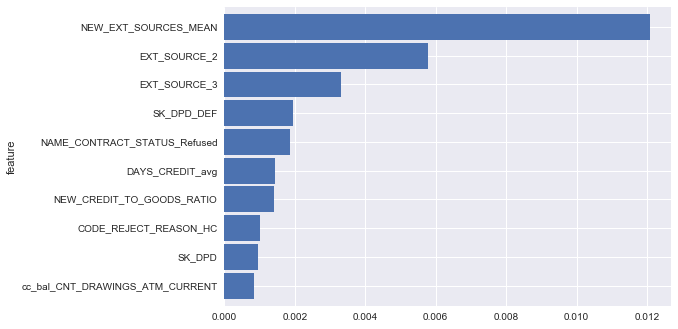

In [66]:
(actual_imp.groupby("feature").importance.mean() - null_imp.groupby("feature").importance.mean()).sort_values().tail(10).plot(kind="barh", width=.9)
plt.show()

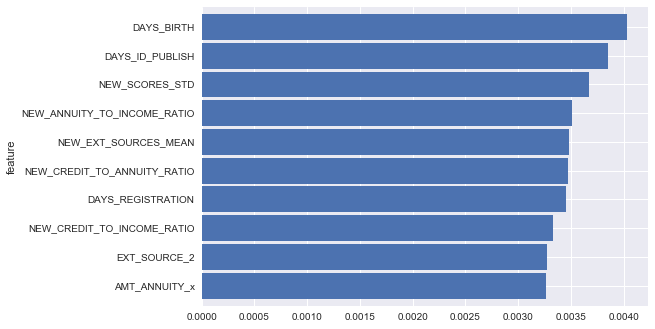

In [58]:
null_imp.groupby("feature").importance.mean().sort_values().tail(10).plot(kind="barh", width=.9)
plt.show()

In [72]:
rlimp1 = ni.relative_importance(actual_imp, null_imp)
rlimp2 = ni.relative_importance2(actual_imp, null_imp)

In [80]:
rlimp1.loc["SK_ID_PREV_x"]

0.56000000000000005

In [84]:
features_selected = [col_ for col_ in list(rlimp1[rlimp1 > .2].index)]
print(len(features_selected))

656


In [93]:
features_selected = [col_ for col_ in list(rlimp2[rlimp2 > .0].index) if not col_.startswith("SK_ID")]
print(len(features_selected))

1283


In [96]:
features_selected = [col_ for col_ in list(imp1[imp1 > .0].index) if not col_.startswith("SK_ID")]
print(len(features_selected))

1348


In [99]:
features_selected = [col_ for col_ in features if not col_.startswith("SK_ID")]
print(len(features_selected))

1419


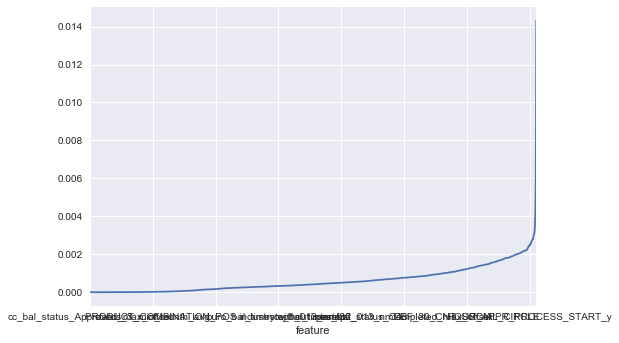

In [92]:
rlimp2.sort_values().plot()
plt.show()

In [100]:
X_num_train = data_train[features_selected].values
X_num_val = data_val[features_selected].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.76515851384193556

1. 0.75816139082616663
2. 0.76239002619826557 rlimp1
3. 0.76486055795697594 rlimp2
4. 0.76319097794387836 imp1

## submission

In [101]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data = data.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    test = test.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for data_ in (buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide):
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")

In [103]:
print(data.shape, test.shape)

(307507, 1423) (48744, 1423)


In [104]:
features = list(data.columns)
features.remove("SK_ID_CURR")
print(len(features))

1422


In [105]:
gc.collect()

7

In [106]:
X_data = data[features].values
y_data = y.TARGET.values
del data, y
gc.collect()

print(X_data.shape)

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 2000
}



xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_data, y_data)

del X_data
gc.collect()

X_test = test[features].values
print(X_test.shape)
pred_test = xgb_clf.predict(X_test)

(307507, 1422)
(48744, 1422)


In [113]:
help(xgb_clf.gbdt)

Help on Booster in module xgboost.core object:

class Booster(builtins.object)
 |  A Booster of of XGBoost.
 |  
 |  Booster is the model of xgboost, that contains low level routines for
 |  training, prediction and evaluation.
 |  
 |  Methods defined here:
 |  
 |  __copy__(self)
 |  
 |  __deepcopy__(self, _)
 |  
 |  __del__(self)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, params=None, cache=(), model_file=None)
 |      Parameters
 |      ----------
 |      params : dict
 |          Parameters for boosters.
 |      cache : list
 |          List of cache items.
 |      model_file : string
 |          Path to the model file.
 |  
 |  __setstate__(self, state)
 |  
 |  attr(self, key)
 |      Get attribute string from the Booster.
 |      
 |      Parameters
 |      ----------
 |      key : str
 |          The key to get attribute from.
 |      
 |      Returns
 |      -------
 |      value : str
 |          The attribute value of the key, returns None if attribute do not exi

In [107]:
np.save("./result/submission-014", pred_test)

In [108]:
import pickle

In [110]:
with open("./models/xgb-014-a", "wb") as ofile:
    pickle.dump(xgb_clf, ofile, 0)

In [111]:
test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-014-A.csv", index=False)